# Assignment 3: LDA Topic Modeling

## Note
Installing Tomotopy locally can return an error, if that's the case run this notebook on Google Colab

## Research Background

LDA is a popular topic modeling algorithm widely used in the fields of Digital Humanities and Social Sciences. In the field of political communication, topic modeling is often applied for analyzing politicians Twitter/X posts, identitying thematic patterns or topics revolving around their posts.

For this assignment, students will work with tweets from two USA politicians, Donald Trump and Bernie Sanders, who are often regarded as right-wing populist and left-wing populist respectively. Right-wing populism often emphasizes nationalism, anti-immigration policies, and a critique of global elites from a culturally conservative perspective, focusing on preserving traditional values and social hierarchies. Left-wing populism prioritizes economic inequality, advocating for the redistribution of wealth, expansion of social services, and empowerment of the working class against the capitalist elite. While both forms of populism appeal to the "common people" against perceived elites and established structures, they diverge significantly in their identification of the elites, proposed solutions, and core ideologies. For a more detailed explanation, you can read the chapter by Macaulay (2019) "Bernie and The Donald: A comparison of left-and right-wing populist discourse" (full reference below).

**Research Questions**
1. What topics are revolving around Donald Trump and Bernie Sanders' posts separately?
2. What are the topic differences between Trump (right-wing popoulist) and Sanders (left-wing populist)?

**Aim:**
1. The first aim of the assignment is to conduct LDA topic modeling. Identify thematic patterns or politics revolving around Trump or Sanders's posts.
2. The second aim is to critically evaluate the results of topic modeling. Try different numbers of topics to see with which settings the topics are more coherent. Critically reflect on the results of LDA topic modeling, discussing them in relation to existing theories about populism.

**Data**
Two datasets are prepared for this assginment. Tweets from Trump and tweets from Sanders. Students are asked to work on these two datasets.

**Methods**
1. Word segamentation
2. Removing stopwords
3. LDA topic modeling
4. Topic evaulation (coherence and human evaluation)
5. Visualization of results.

**References**
1. Macaulay, M. (2019). Bernie and the Donald: A comparison of Left-and Right-wing populist discourse. *Populist discourse: International perspectives*, 165-195.





## Setup

### Q1. Install necessary libraries, including `tomotopy` and `little_mallet_wrapper`, and import them

In [1]:
# Q1 (code)

# Instal libraries
# Install the tomotopy library
!pip install tomotopy
# Install the little_mallet_wrapper library
!pip install little_mallet_wrapper

# Link the Google Drive with Colab
# Importing the drive module from the google.colab library
from google.colab import drive
# Mounting Google Drive at the '/content/drive' directory
drive.mount('/content/drive')

# Import libraries
# Import the tomotopy library and name it as tp, used for topic modeling
import tomotopy as tp
# Import the little_mallet_wrapper library for interacting with the Mallet topic modeling tool
import little_mallet_wrapper
# Import the seaborn library for data visualization
import seaborn

# Import glob and pathlib for working with files and the file system.
# Importing the glob module for file path pattern matching
import glob
# Importing the Path class from the pathlib module for file path manipulation and file system operations
from pathlib import Path

# Importing the pandas library and aliasing it as pd, used for data analysis and manipulation
import pandas as pd


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.2/17.2 MB 26.4 MB/s eta 0:00:00
Mounted at /content/drive


## Data preprocessing

### Q2. Load the two datasets and concatenate them

The goal is to run topic modelling on the combined dataset of Sanders and Trump's tweets

In [2]:
# Q2 (code)

# Because my corpus is a collection of two separate CSV files,
# the following steps demonstrate how to process this kind of files and prepare them for analysis before topic modeling.

# Make a variable and assign it the file path for the directory that contains the CSV files, in order to get the necessary files.
# Below, we'll call these files our training data as they're used to train our topic model, which learns and extracts topics from them.
directory = "/content/drive/MyDrive/A3+A3prepare/tweets_sanders_trump"
# Use the glob.gob() function to make a list of all (*) the .csv files in that directory
files = glob.glob(f"{directory}/*.csv")

### Q3. Clean the data

Transform all tweets to lowercase, remove stopwords, punctuation, and numbers. Add the processed text to a list called `training_data`.
Create a list with the content of the tweets (`original_texts`) and a list that allows you to identify both the author of the tweet and its ID (`titles`).


In [3]:
# Q3(code)

# Import the Natural Language Toolkit (NLTK) library for natural language processing tasks
import nltk
# Import the stopwords corpus from NLTK
from nltk.corpus import stopwords
# Import word_tokenize for tokenizing text into words
from nltk.tokenize import word_tokenize
# Import the string module for cleaning punctuation
import string

# Download the NLTK stopwords corpus
nltk.download('stopwords')
# Download the NLTK punkt corpus
nltk.download('punkt')

# Define sets for stopwords and punctuation
stop_words = set(stopwords.words('english'))
punctuation = set(string.punctuation)

# Initialize lists to store processed text data, original text content, and author/ID information
training_data = [] # Create a master list to store processed text data
original_texts = [] # Create a list to store the original content of tweets
titles = []  # Create a list to store author and ID information of the text

# Clean the data
# Import the regular expression module
import re
# Loop through the list of files
for file in files:
    # Read the text content from the file
    text = open(file, encoding='utf-8').read()

    # Process the text using little_mallet_wrapper.process_string() function to transform all the text to lowercase as well as remove stopwords, punctuation, and numbers
    processed_text = little_mallet_wrapper.process_string(text, numbers='remove')

    # Use the re.sub() function to remove URLs, user mentions, and other specified patterns from the text and replace them with an empty string
    # It's worth noting that we've chosen to first use the little_mallet_wrapper.process_string() function, followed by re.sub(), for data removal,
    # due to the possibility of the former generating data that needs to be removed in the second step, which could potentially result in retaining interfering data
    processed_text = re.sub(r"http\S+|www\S+|https\S+|\/\/t|co\/|\@\w+|realdonaldtrump", '', processed_text, flags=re.MULTILINE)

    # Tokenize the text using word_tokenize() function
    tokens = word_tokenize(processed_text)

    # Filter out stopwords, punctuation, and pure numbers
    filtered_tokens = [token for token in tokens if token not in stop_words and token not in punctuation and not token.isdigit()]

    # Add the processed text to the master list training_data
    training_data.append(filtered_tokens)
    # Add the original text content to the list original_texts
    original_texts.append(text)
    # Extract relevant parts of the file name as titles, and add them to the titles list
    titles.append(Path(file).stem)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


## LDA topic modelling

### Q4. Train a an LDA topic model with `tomotopy`

In [17]:
# Q4 (code)

# Number of topics to return
num_topics = 10
# Numer of topic words to print out
num_topic_words = 10

# Initialize the model with the number of topics to be learned set to num_topics
model = tp.LDAModel(k=num_topics)
# Convert each document in the training data to a list of words and add it to the model for training
for text in training_data:
    # Join the list of words into a single string
    text_str = ' '.join(text)
    # Split the string into a list of words and add it to the model for training
    model.add_doc(text_str.strip().split())

# Print a message indicating the beginning of the topic model training process
print("Topic Model Training...\n\n")

# Number of iterations for each model training session
# Given the dataset's size of over 30,000 tweets, the chosen iteration values are relatively high
# The specific numerical values should be determined based on the dataset's characteristics
iterations = 100
# Loop through iterations from 0 to 2000 (exclusive), with a step size of 'iterations'
for i in range(0, 2000, iterations):
    # Train the model with 'iterations' iterations
    model.train(iterations)
    # Display the current iteration and its corresponding log-likelihood
    print(f'Iteration: {i}\tLog-likelihood: {model.ll_per_word}')

Topic Model Training...


Iteration: 0	Log-likelihood: -8.873169013825219
Iteration: 100	Log-likelihood: -8.751696704208559
Iteration: 200	Log-likelihood: -8.712082985640274
Iteration: 300	Log-likelihood: -8.682301631082057
Iteration: 400	Log-likelihood: -8.659714842540907
Iteration: 500	Log-likelihood: -8.650981840589363
Iteration: 600	Log-likelihood: -8.65746191721207
Iteration: 700	Log-likelihood: -8.640931322150172
Iteration: 800	Log-likelihood: -8.628800850513693
Iteration: 900	Log-likelihood: -8.636366743828448
Iteration: 1000	Log-likelihood: -8.626246488007185
Iteration: 1100	Log-likelihood: -8.629731965427833
Iteration: 1200	Log-likelihood: -8.624475767762302
Iteration: 1300	Log-likelihood: -8.627511820339718
Iteration: 1400	Log-likelihood: -8.632261704089741
Iteration: 1500	Log-likelihood: -8.631804183326729
Iteration: 1600	Log-likelihood: -8.633227162955903
Iteration: 1700	Log-likelihood: -8.628781635341738
Iteration: 1800	Log-likelihood: -8.63127832036327
Iteration: 1900	Log

### Q5. Print out the top words for each topic and manually evaluate their coherence


In [18]:
# Q5a (code)

# Initialize an empty list to store the concatenated words for each topic
topics = []
# Initialize an empty list to store the individual words for each topic
topic_individual_words = []

# Iterate through each topic number from 0 to (num_topics - 1)
for topic_number in range(0, num_topics):
    # Retrieve the top num_topic_words words for the current topic and concatenate them into a string
    topic_words = ' '.join(word for word, prob in model.get_topic_words(topic_id=topic_number, top_n=num_topic_words))
    # Append the concatenated words for the current topic to the topics list
    topics.append(topic_words)
    # Split the concatenated words into individual words and append to the topic_individual_words list
    topic_individual_words.append(topic_words.split())
    # Print the topic number and its corresponding words
    print(f"✨Topic {topic_number}✨\n\n{topic_words}\n")

✨Topic 0✨

get many america first way total left fbi every coming

✨Topic 1✨

must day state economy see national news better court know

✨Topic 2✨

never house bad crime party law record political illegal story

✨Topic 3✨

time like republican vote campaign money long could real administration

✨Topic 4✨

people americans right tax america today congress working million workers

✨Topic 5✨

states much nothing russia jobs security take hunt complete also

✨Topic 6✨

strong need trade wall let two keep getting night love

✨Topic 7✨

case happy forward mexico farmers market washington press next open

✨Topic 8✨

sensanders trump must health country need care make president millions

✨Topic 9✨

great president trump democrats thank country new fake would big



In [ ]:
# Q5b (words)
# Describe what each topic is about. What ideas, values, or situations do these keywords refer to?

**Topic Theme**

✨Topic 0✨: The phrase indicates a discussion likely centered around the implementation and effects of the "America First" policy. This may involve examining different approaches to advancing this agenda, while also considering the discussions from left-leaning groups. Additionally, there could be a focus on ongoing developments and challenges involving the Federal Bureau of Investigation (FBI). Overall, the theme seems to revolve around the pursuit of "America First" initiatives amid political and institutional complexities.

✨Topic 1✨: The key words imply that this topic is likely to emphasize the importance of staying informed about national affairs. It may include discussions about monitoring the state of the economy, staying updated with national news, and understanding the workings of the court system. Overall, the focus appears to be on the necessity of being knowledgeable about current events and national issues.

✨Topic 2✨ The keywords hint at a discussion centered around various aspects of crime, political parties, and legal matters. It may delve into debates on law enforcement effectiveness, political accountability, and legal cases. Overall, the topic seems to revolve around issues related to crime, politics, and legality.

✨Topic 3✨ The keywords hint at a discussion likely centered around various aspects of Republican politics. This may include analyses of Republican voter preferences over time, the role of campaign finance in shaping political decisions, and assessments of the longevity and authenticity of the administration. Overall, the theme appears to focus on the temporal, political, and financial dimensions of Republican governance.

✨Topic 4✨ The keywords indicate a discussion likely centered around various aspects of American society and governance. This may include debates on citizens' rights, taxation policies, the current state of the nation, legislative activities in Congress, and the role of the workforce. Overall, the theme seems to revolve around issues concerning American rights, taxation, governance, and labor.

✨Topic 5✨ The keywords hint at a discussion likely centered around various aspects of state governance, national security, international relations with Russia, job creation, and completion of objectives. This topic may involve analyses of state-level policies, considerations of security measures, discussions on diplomatic relations with Russia, efforts to promote job growth, and endeavors to achieve certain goals. Overall, the theme seems to encompass a broad range of topics related to states, security, and international affairs.

✨Topic 6✨ The keywords "strong need trade wall let two keep getting night love" suggest a discussion likely centered around various aspects of trade policies, border security, and emotional sentiments. This topic may involve debates on the necessity of robust trade agreements, arguments for and against the construction of a border wall, strategies for maintaining stability amidst conflicting interests, persistence in pursuing objectives, and expressions of affection or support for certain initiatives. Overall, the theme encompasses a broad range of topics related to trade, border security, policy implementation, and emotional connections.

✨Topic 7✨ The keywords suggest a discussion likely centered around various topics including a legal case or situation, positive outlook, progress or advancement, relations with Mexico, agriculture and farming, market activities, developments in Washington, and media coverage. This topic may involve analyses of legal proceedings, expressions of satisfaction, efforts to move forward, discussions on trade or diplomatic relations with Mexico, agricultural policies, market trends, political activities, and press coverage of relevant events. Overall, the theme encompasses a broad spectrum of subjects related to legal, social, economic, and political dynamics.

✨Topic 8✨ The keywords suggest a discussion likely centered around various aspects of healthcare policy, involving political figures such as Senator Bernie Sanders and President Trump. This topic may involve debates on the healthcare needs of the country, efforts to improve healthcare access and quality, and considerations of the impact on millions of individuals. Overall, the theme encompasses a broad range of topics related to healthcare reform, political leadership, and public health concerns.

✨Topic 9✨ The keywords suggest a discussion likely focused on various aspects of political dynamics, including assessments of President Trump's leadership, Democratic Party actions, expressions of gratitude towards the country, discussions on emerging developments, critiques of misinformation, and considerations of significant events. This topic may involve debates on the achievements and shortcomings of the current administration, analyses of partisan dynamics, expressions of national pride or appreciation, discussions on the validity of information, and assessments of the impact of major events on political discourse. Overall, the theme encompasses a broad spectrum of topics related to political leadership, party dynamics, public sentiment, and the dissemination of information.


**Evaluate Coherence Manually**

✨Topic 0✨: The coherence of keywords is moderate. While they all relate to American politics and societal issues, their connection is not immediately apparent or direct.

✨Topic 1✨: The coherence of keywords is high. They all center around national economy, news coverage, court systems, and knowledge acquisition, forming a coherent theme.

✨Topic 2✨: The coherence of keywords is high. They all pertain to crime, political parties, law, and narratives, forming a cohesive theme.

✨Topic 3✨: The coherence of keywords is high. They all involve the Republican party, voting, campaign finances, and governance, forming a unified theme.

✨Topic 4✨: The coherence of keywords is high. They all revolve around American rights, taxation, Congress, employment, and the labor force, forming a coherent theme.

✨Topic 5✨: The coherence of keywords is moderate. While they involve states, Russia, jobs, and security, their connection is not entirely clear.

✨Topic 6✨: The coherence of keywords is moderate. Despite involving trade, wall, and love, their connection is not immediately apparent.

✨Topic 7✨: The coherence of keywords is moderate. They involve a case, Mexico, farmers market, and Washington, but their connection is not immediately clear.

✨Topic 8✨: The coherence of keywords is high. They all relate to Senator Sanders, President Trump, healthcare, and the country, forming a cohesive theme.

✨Topic 9✨: The coherence of keywords is moderate. Despite involving President Trump, Democrats, gratitude, and fake news, their connection is not immediately obvious.

## Topic coherence

Use `tomotopy`'s [`.coherence()`](https://bab2min.github.io/tomotopy/v0.10.0/en/coherence.html) function to automatically calculate the topic coherence.

The coherence value can vary from `0` (no coherence) to `1` (maximum coherence). Interpret the results and, if needed, retrain the model using a different number of topics.

In [19]:
# Initial coherence score (topic number is 10)
# There are different metrics for coherence, we choose `c_v`

# Create a 'c_v' coherence calculator instance based on the topic model 'model'
coh = tp.coherence.Coherence(model, coherence='c_v')
# Compute the average coherence score of the entire topic model
average_coherence = coh.get_score()
# Compute coherence score for each topic, iterating through each topic index
coherence_per_topic = [coh.get_score(topic_id=k) for k in range(model.k)]

# Print the selected coherence metric, which is 'c_v'
print('==== Coherence : {} ===='.format('c_v'))
# Display the average coherence score and coherence score for each topic
print('Average:', average_coherence, '\nPer Topic:', coherence_per_topic)
print()

==== Coherence : c_v ====
Average: 0.43384822564199566 
Per Topic: [0.3756661757826805, 0.3116182044148445, 0.5209983438253403, 0.31933178603649137, 0.5788237378001213, 0.3619931101799011, 0.33865446150302886, 0.4738131672143936, 0.5675150394439697, 0.49006823021918533]



### Q6. Interpret topic coherence

Report the following:
- number of topics you initially used to train the model and the coherence score you got
- changes made to the number of topics and new coherence scores obtained

**Initial Training:**  
The model was initially trained with 10 topics, resulting in a coherence score of 0.43384822564199566

**Changes in the Number of Topics and New Coherence Scores:**  
Number of topics: 15
Coherence score: 0.43282288094361626

Number of topics: 20
Coherence score: 0.5296856259461492

Number of topics: 25
Coherence score: 0.5822564204484225

Number of topics: 30
Coherence score: 0.6733424600213767

Number of topics: 35
Coherence score: 0.7028617361932994

Number of topics: 40
Coherence score: 0.750606269016862

Number of topics: 50
Coherence score: 0.7933332085558213

The iterative process suggests a potential correlation between the number of topics and coherence scores, as coherence scores generally tend to increase with an increase in the number of topics.

### X1. Optional question 1
(This question is not compulsory, it only allows you to get an extra point.)

Create a function to plot the average coherence for models with different number of topics.

100%|██████████| 5/5 [06:46<00:00, 81.38s/it]


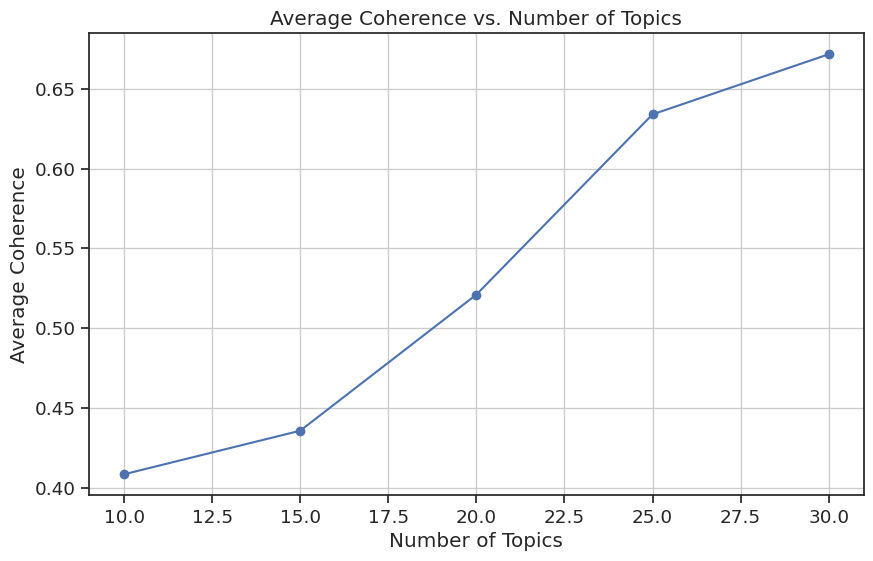

In [33]:
# Import matplotlib.pyplot for plotting
import matplotlib.pyplot as plt
# Import numpy for numerical computations
import numpy as np
# Import tqdm for displaying progress bars
import tqdm

# Train topic models with different numbers of topics and calculate the average coherence scores
def train_model(training_data, num_topics_list, iterations=100):
    # Initialize an empty list to store average coherence scores
    average_coherence_list = []

    # Iterate over the list of numbers of topics while displaying a progress bar
    for num_topics in tqdm.tqdm(num_topics_list):
        # Initialize the model with the number of topics
        model = tp.LDAModel(k=num_topics)

        # Convert each document in the training data to a list of words and add it to the model for training
        for text in training_data:
            text_str = ' '.join(text)
            model.add_doc(text_str.strip().split())

        # Train the model
        for i in range(0, 2000, iterations):
            model.train(iterations)

        # Calculate coherence score
        coh = tp.coherence.Coherence(model, coherence='c_v')
        average_coherence_list.append(coh.get_score())

    return average_coherence_list

# Plot the average coherence scores against the number of topics
def plot_coherence(num_topics_list, coherence_scores):
    plt.figure(figsize=(10, 6)) # Create a new figure with specified size
    plt.plot(num_topics_list, coherence_scores, marker='o', linestyle='-') # Plot the coherence scores as a line graph with markers
    plt.title('Average Coherence vs. Number of Topics') # Set the title of the plot
    plt.xlabel('Number of Topics') # Set the label for the x-axis
    plt.ylabel('Average Coherence') # Set the label for the y-axis
    plt.grid(True) # Add grid lines to the plot
    plt.show() # Display the plot

# Example usage:
num_topics_list = [10, 15, 20, 25, 30]  # Define the list of numbers of topics to evaluate
coherence_scores = train_model(training_data, num_topics_list)  # Train models and calculate coherence scores
plot_coherence(num_topics_list, coherence_scores)  # Plot the average coherence vs. number of topics


### Q7. Topic distributions
Calculate the topic distributions for all tweets and get the top documents for some topics (between 2 and 5) that you think could be more representative of Sanders or Trump.

In [48]:
# Q7a (code)

# Generates a list of topic distributions for each document in the model
topic_distributions = [list(doc.get_topic_dist()) for doc in model.docs]

# Number of topics to return
num_topics = 15
# Numer of topic words to print out
num_topic_words = 10

# Print out top 10 words for each topic
print("\nTopic Model Results:\n\n")

# Initialize an empty list to store the concatenated words for each topic
topics = []
# Initialize an empty list to store individual words for each topic
topic_individual_words = []

# Iterate over each topic in the model
for topic_number in range(model.k):
    # Retrieve the top N words for the current topic and join them into a single string
    topic_words = ' '.join(word for word, prob in model.get_topic_words(topic_id=topic_number, top_n=num_topic_words))
    # Append the concatenated words to the 'topics' list
    topics.append(topic_words)
    # Split the concatenated words into individual words and append to the 'topic_individual_words' list
    topic_individual_words.append(topic_words.split())
    # Print the topic number and its corresponding top words
    print(f"✨Topic {topic_number}✨\n\n{topic_words}\n")


Topic Model Results:


✨Topic 0✨

poorly transcripts answer nadler haters dobbs negotiations kayleighmcenany ron maybe

✨Topic 1✨

news also got really long order hard could called another

✨Topic 2✨

vote senate want wall coming take york looking totally law

✨Topic 3✨

right crisis let many years take paid top middle leave

✨Topic 4✨

never house make nothing job republicans well trade party best

✨Topic 5✨

see two made political congratulations gopchairwoman team men ivankatrump danscavino

✨Topic 6✨

great president trump people get fake new biden time many

✨Topic 7✨

day court forward live full better trying far remember lost

✨Topic 8✨

since getting days wants almost find dangerous members special record

✨Topic 9✨

country would like going republican world last know campaign say

✨Topic 10✨

democrats big america border even years back whitehouse joe jobs

✨Topic 11✨

sensanders people must trump health care americans need american time

✨Topic 12✨

thank american today news

In [53]:
# Calculate the topic distributions for all tweets
topic_results = [{'document': title, 'topic_distribution': distribution} for title, distribution in zip(titles, topic_distributions)]

# Create a DataFrame from the results
df = pd.DataFrame(topic_results)

# Extract the topic words as column names
column_names = [f"Topic {number} {' '.join(topic[:4])}" for number, topic in enumerate(topic_individual_words)]

# Create a DataFrame containing the topic distributions
topic_dist_df = pd.DataFrame(df['topic_distribution'].tolist(), columns=column_names)

# Concatenate the original DataFrame with the new DataFrame containing topic distributions
df = pd.concat([df['document'], topic_dist_df], axis=1)

# Display the DataFrame
df

,document,Topic 0 poorly transcripts answer nadler,Topic 1 news also got really,Topic 2 vote senate want wall,Topic 3 right crisis let many,Topic 4 never house make nothing,Topic 5 see two made political,Topic 6 great president trump people,Topic 7 day court forward live,Topic 8 since getting days wants,Topic 9 country would like going,Topic 10 democrats big america border,Topic 11 sensanders people must trump,Topic 12 thank american today news,Topic 13 ever night korea despite,Topic 14 want states government bill
0,trump_tweets,1.900884e-02,0.074222,0.048756,0.026421,0.086464,3.538763e-02,0.198040,0.061855,0.037695,0.102253,0.110924,3.401341e-07,0.105366,0.036092,0.057515
1,sanders_tweets,7.193880e-07,0.027324,0.005019,0.133331,0.024475,7.636054e-07,0.001079,0.041532,0.027384,0.099627,0.004889,4.934861e-01,0.009375,0.009036,0.123441


In [75]:
## Sanders
# Select Sanders's topics to explore
selected_topics = [1, 11, 14]

# Ensure selected_topics are within the range of topic_distributions
num_topics = len(topic_distributions[0]) if topic_distributions else 0
selected_topics = [topic_id for topic_id in selected_topics if topic_id < num_topics]

# Print top documents for each selected topic (Sanders)
for topic_id in selected_topics:
    print(f"Top documents for Topic {topic_id}:")
    # Sort documents based on probability of the selected topic
    top_documents = sorted(enumerate(topic_distributions), key=lambda x: x[1][topic_id], reverse=True)[:3] #get top 3 documents
    for doc_id, topic_dist in top_documents:
        doc_title = titles[doc_id]
        doc_content = training_data[doc_id]
        prob = topic_dist[topic_id]
        print(f"Document {doc_title}: {doc_content} (Probability: {prob})")
    print()

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Interpret the results above. Are there topics that have top tweets only by one politician? Why do you think these topics are more representative of one of the two politicians' views?

Based on the topic model results, it's evident that certain topics are more closely associated with either Sanders or Trump. For instance, topics 1, 11, and 14 appear to be predominantly represented by Sanders' tweets, while the rest are more aligned with Trump's discourse.

This discrepancy in topic representation could be attributed to each politician's unique priorities and communication styles. Sanders may tend to focus more on issues like news coverage, healthcare, and government support, as reflected in topics 1, 11, and 14. On the other hand, Trump's tweets may be centered around topics such as immigration, economy, and political rivalries, which dominate the remaining topics.

These findings underscore the distinct messaging strategies and policy emphases of each politician, highlighting their respective areas of focus and priorities.

## Large scale analysis

### Q8. Create a random sample of the whole dataset and visualize the topic distributions for the sampled tweets

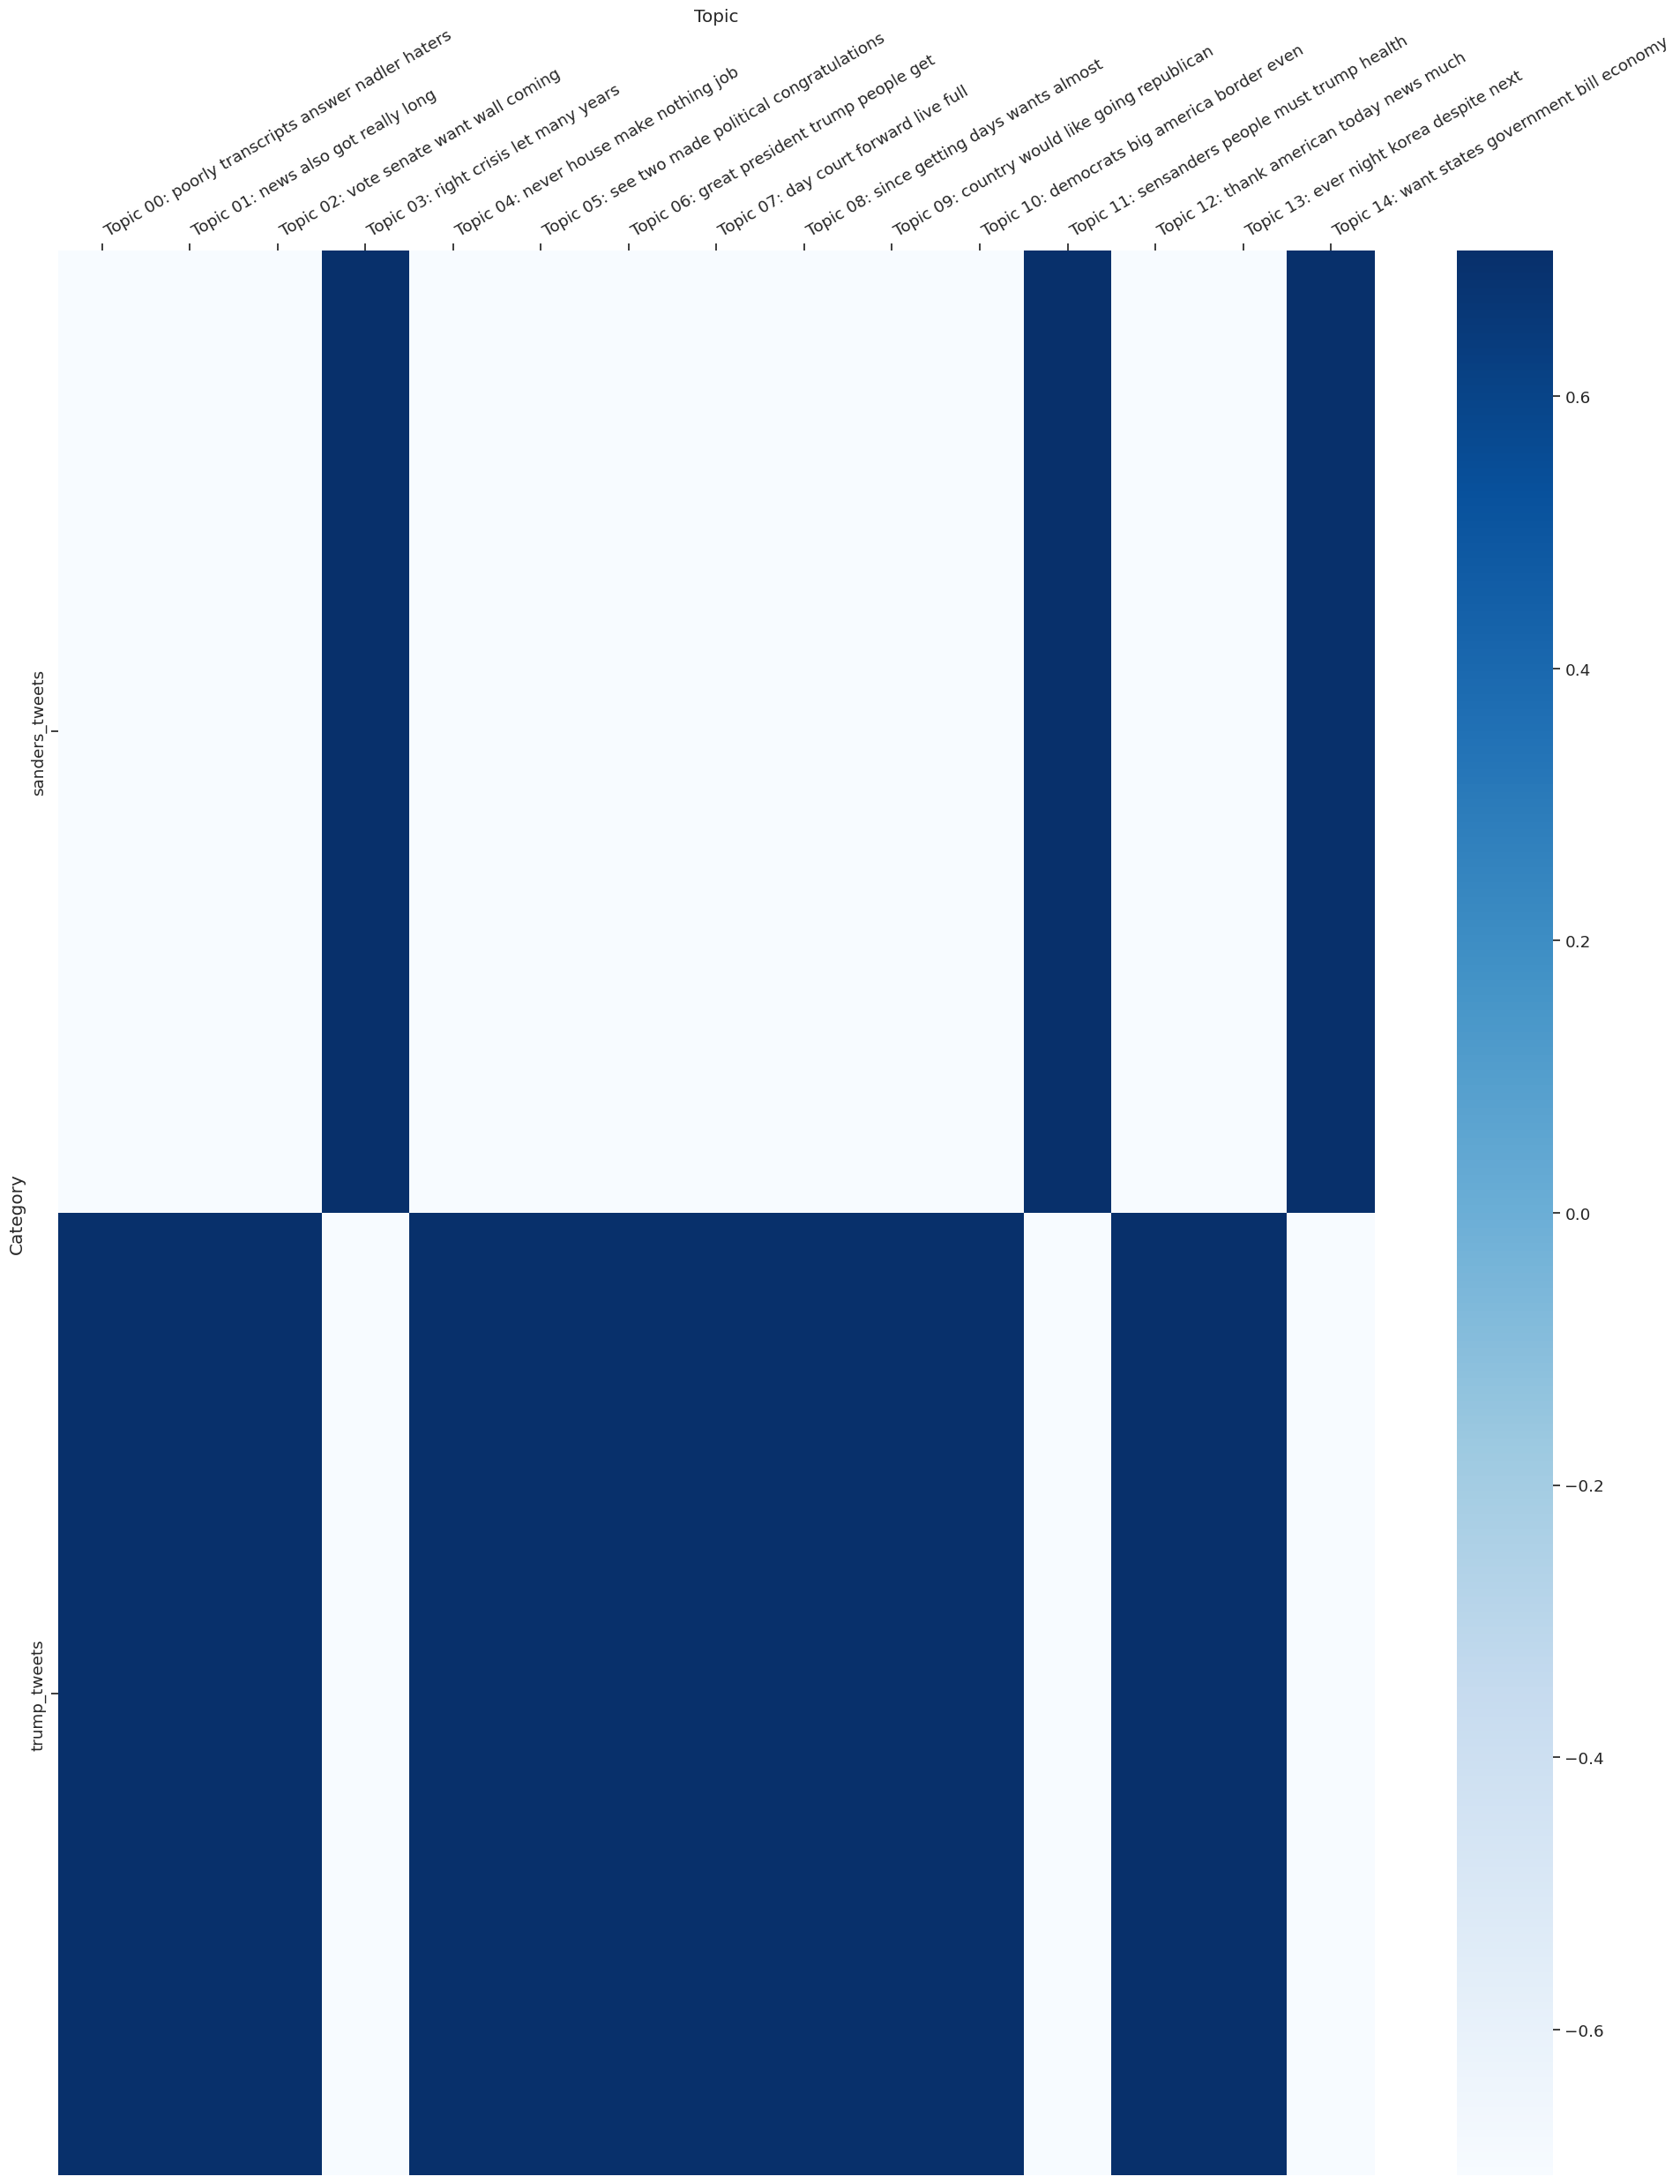

In [57]:
# Q8 (code)
# Create a heatmap using the random sample
# Tip: to display more than 20 tweets you have to change the values of `dim =` in sns.heatmap()

# Crete a sample of tweets
from random import sample

# Determine the sample size based on the length of the titles list
sample_size = min(100, len(titles))

# Sample tweets from the titles list
target_labels = sample(titles, sample_size)

def plot_categories_by_topics_heatmap(labels,
                                      topic_distributions,
                                      topic_keys,
                                      output_path=None,
                                      target_labels=None,
                                      color_map=sns.cm.rocket_r,
                                      dim=None):

    # Combine the labels and distributions into a list of dictionaries.
    dicts_to_plot = []
    for _label, _distribution in zip(labels, topic_distributions):
        if not target_labels or _label in target_labels:
            for _topic_index, _probability in enumerate(_distribution):
                dicts_to_plot.append({'Probability': float(_probability),
                                      'Category': _label,
                                      'Topic': 'Topic ' + str(_topic_index).zfill(2) + ': ' + ' '.join(topic_keys[_topic_index][:5])})

    # Create a dataframe, format it for the heatmap function, and normalize the columns.
    df_to_plot = pd.DataFrame(dicts_to_plot)
    df_wide = df_to_plot.pivot_table(index='Category',
                                     columns='Topic',
                                     values='Probability')
    df_norm_col = (df_wide - df_wide.mean()) / df_wide.std()

    # Show the final plot.
    if dim:
        plt.figure(figsize=dim)
    sns.set(style='ticks', font_scale=1.2)
    ax = sns.heatmap(df_norm_col, cmap=color_map)
    ax.xaxis.tick_top()
    ax.xaxis.set_label_position('top')
    plt.xticks(rotation=30, ha='left')
    plt.tight_layout()
    plt.show()

# Call the function to plot the heatmap
plot_categories_by_topics_heatmap(titles,
                                  topic_distributions,
                                  topic_individual_words,
                                  target_labels=target_labels,
                                  color_map='Blues',
                                  dim=(20, 25))

### Q9. Interpret the heatmap
Do you see any pattern in the probability distributions of topics for each politician?

Are there topics that are more likely for one of the two politicians?

The topics 3, 11 and 14 appear to be more frequently associated with Sanders. This suggests a focus on addressing critical issues such as healthcare, economic reforms, and social welfare programs. Sanders' emphasis on these topics underscores his commitment to advocating for policies that prioritize the needs of the American people, particularly in areas of healthcare accessibility, economic equality, and support for marginalized communities, including women.

The rest topics are more discussed by Trump. The prevalence of topics such as "news also got really long order hard," "great president trump people get fake new biden time many," and "thank american today news much good done way total impeachment" suggests a stronger association with Trump. This pattern underscores Trump's focus on issues related to media coverage, his presidency's accomplishments, and responses to impeachment proceedings. Additionally, the emphasis on issues like immigration, border security, and job creation aligns with Trump's policy priorities and political rhetoric, further reinforcing his influence on these discussions.

Trump cover a wider array of topics. He discusses diverse subjects such as media coverage, border security, job creation, and impeachment, showcasing his multifaceted approach to communication and governance. Conversely, Sanders tends to focus on more specific issues like healthcare, American workers' needs, and criticism of Trump's policies.

### X2. Optional question 2
(This question is not compulsory, it only allows you to get an extra point)

Make the sample balanced, with 50 tweets by Trump and 50 by Sanders.

In [60]:
# X2 (code)
# Count the number of tweets by Trump and Sanders
num_trump_tweets = len([title for title in titles if 'Trump' in title])
num_sanders_tweets = len([title for title in titles if 'Sanders' in title])

# Sample 50 tweets from each candidate's tweets
Trump_sample = sample([title for title in titles if 'Trump' in title], min(num_trump_tweets, 50))
Sanders_sample = sample([title for title in titles if 'Sanders' in title], min(num_sanders_tweets, 50))

# Combine the samples
balanced_sample = Trump_sample + Sanders_sample

### X3. Optional question 3
(This question is not compulsory, it only allows you to get an extra point)

Extend the analysis to all the tweets in the dataset.

In [ ]:
# X3 (code and words)
# Tip: plotting a heatmap for thousands of tweets is not practical.
# Make a comparison based on the numerical values in the `df_norm_col` dataframe (see Week 6 notebook)

In [70]:
# Convert the topic distributions and tweet titles into a DataFrame
df_to_plot = pd.DataFrame({
    'Probability': [float(probability) for distribution in topic_distributions for probability in distribution],
    'Tweet': [title for title in titles for _ in range(len(topic_distributions[0]))],
    'Topic': ['Topic ' + str(topic_index).zfill(2) + ': ' + ' '.join(topic_words[:5])
              for topic_index, topic_words in enumerate(topic_individual_words)
              for _ in range(len(titles))]
})

# Pivot the DataFrame
df_wide = df_to_plot.pivot_table(index='Tweet', columns='Topic', values='Probability')

# Normalize the values in each column (topic) by subtracting the mean and dividing by the standard deviation
df_norm_col = (df_wide - df_wide.mean()) / df_wide.std()
print(df_norm_col)

Topic           Topic 00: poorly transcripts answer nadler haters  \
Tweet                                                               
sanders_tweets                                                NaN   
trump_tweets                                                  NaN   

Topic           Topic 01: news also got really long  \
Tweet                                                 
sanders_tweets                                  NaN   
trump_tweets                                    NaN   

Topic           Topic 02: vote senate want wall coming  \
Tweet                                                    
sanders_tweets                                     NaN   
trump_tweets                                       NaN   

Topic           Topic 03: right crisis let many years  \
Tweet                                                   
sanders_tweets                                    NaN   
trump_tweets                                      NaN   

Topic           Topic 04: never house ma